### Problem 1


In [41]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, QuantumRegister
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
from qiskit.quantum_info import random_statevector, partial_trace
import qiskit.quantum_info as qi
from qiskit.circuit.library import QFT

In [42]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.compose(QFT(N_COUNT, inverse = True), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [43]:
a = 7
N = 15
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print("*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 11111000
Corresponding Phase: 0.96875
Result: r = 1
Guessed Factors: 15 and 1

ATTEMPT 2:
Register Reading: 11000010
Corresponding Phase: 0.7578125
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: {guess} ***
*** Non-trivial factor found: {guess} ***


### Problem 2


Here I will apply the oracle to find the solution of the function $$f = (\neg x_1\lor x_2) \land(x_3)$$. 

In [44]:
def OR(ckt, qubits, target_qubit):
    """Apply logical OR to the qubits and store the result in the target_qubit."""
    for qubit in qubits:
        ckt.x(qubit)
    ckt.mct(qubits, target_qubit)
    ckt.x(target_qubit)
    for qubit in qubits:
        ckt.x(qubit)

def AND(ckt, qubits, target_qubit):
    """Apply logical AND to the qubits and store the result in the target_qubit."""
    ckt.mct(qubits, target_qubit)

def oracle():
    qc = QuantumCircuit(6)
    qc.x(0)
    OR(qc, [0,1], 3)
    AND(qc, [2,3], 4)
    qc.cx(4,5)
    AND(qc, [2,3], 4)
    OR(qc, [0,1], 3)
    qc.x(0)

    U_w = qc.to_gate()
    U_w.name = "U$_w$"
    return U_w

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

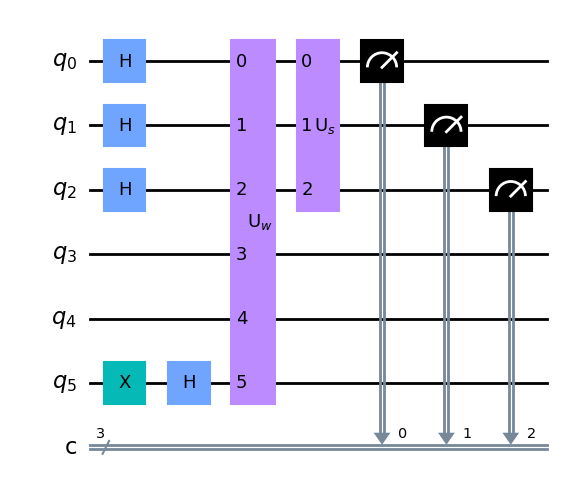

In [51]:
grover_circuit = QuantumCircuit(6,3)
grover_circuit.x(5)
grover_circuit.h(5)
for i in range(3):
    grover_circuit.h(i)
for i in range(1):
    grover_circuit.append(oracle(), list(range(6)))
    grover_circuit.append(diffuser(3), [0,1,2])
for i in range(3):
    grover_circuit.measure(i,i)
grover_circuit.draw('mpl')
#oracle().draw('mpl')

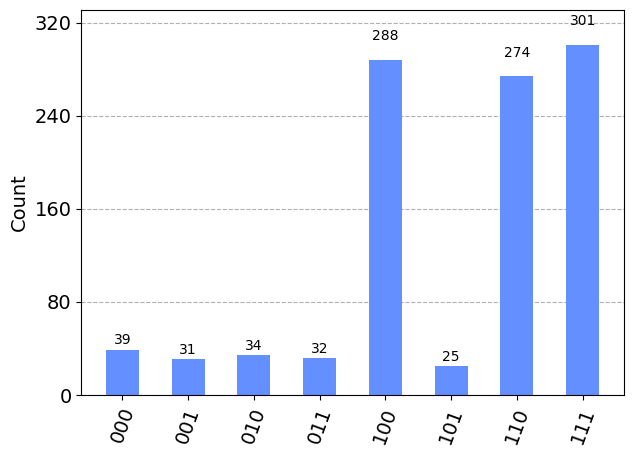

In [52]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

As we can can observe from the result, the SAT solver gives the required solution to the given function f